In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

In [2]:
from dataset import CANDataset
import torch
from torchvision import transforms, datasets
import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
train_dataset = CANDataset(
    root_dir='../Data/TFrecord_w29_s15/1/',
    window_size=29, is_train=True)
# train_dataset.total_size = 1000
train_sampler = None
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=256, shuffle=False,
    num_workers=2, pin_memory=True, sampler=train_sampler)

In [3]:
val_dataset = CANDataset(
    root_dir='../Data/TFrecord_w29_s15/1/',
    window_size=29, is_train=False)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=2048, shuffle=False,
    num_workers=8, pin_memory=True, sampler=None)

# Baseline Model

In [27]:
from networks.inception import InceptionResnet
from networks.simple_cnn import BaselineCNNClassifier
from SupContrast.networks.resnet_big import SupCEResNet

In [28]:
# model = InceptionResnet(n_classes = 5)
# baseline_model = BaselineCNNClassifier(n_classes=5)
baseline_model = SupCEResNet(num_classes=5)

In [29]:
model_path = './save/resnet18_lr0.001_bs256_50epochs_042522_111126_cosine/models/ckpt_epoch_30.pth'
ckpt = torch.load(model_path)
state_dict = ckpt['model']
baseline_model.load_state_dict(state_dict=ckpt['model'])

<All keys matched successfully>

In [30]:
import numpy as np
total_pred = np.empty(shape=(0), dtype=int)
total_label = np.empty(shape=(0), dtype=int)
total_embs = np.empty(shape=(0, 512), dtype=float)

baseline_model = baseline_model.cuda()
baseline_model.eval()
with torch.no_grad():
    for images, labels in tqdm.tqdm(val_loader):
        images = images.cuda(non_blocking=True)
        embs = baseline_model.encoder(images)
        outputs = baseline_model(images)
        _, pred = outputs.topk(1, 1, True, True)
        pred = pred.t().cpu().numpy().squeeze(0)
        embs = embs.cpu().numpy()
        total_embs = np.concatenate((total_embs, embs), axis=0)
        total_pred = np.concatenate((total_pred, pred), axis=0)
        total_label = np.concatenate((total_label, labels), axis=0)

100%|██████████| 162/162 [03:13<00:00,  1.19s/it]


In [31]:
from utils import cal_metric, draw_confusion_matrix
cm, results = cal_metric(total_label, total_pred)
results

{'fnr': array([0.00439855, 0.13811519, 0.14339974, 0.07659597, 0.07730589]),
 'rec': array([0.99995601, 0.99861885, 0.998566  , 0.99923404, 0.99922694]),
 'pre': array([0.99939432, 1.        , 0.99965081, 0.99994714, 0.99995165]),
 'f1': array([0.99967509, 0.99930895, 0.99910811, 0.99959046, 0.99958916])}

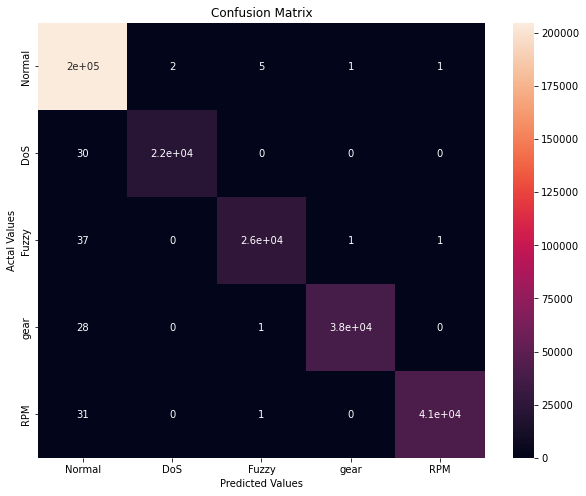

In [57]:
draw_confusion_matrix(cm)

In [39]:
classes = ['Normal', 'DoS', 'Fuzzy', 'gear', 'RPM']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd',]
n_classes = len(classes)

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(n_classes):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(classes)

In [41]:
np.random.seed(100)
indices = np.empty(shape=(0), dtype=int)
num_samples = 2000
for c in range(n_classes):
    idx_c = np.where(total_label==c)[0]
    idx_c = np.random.choice(idx_c, num_samples, replace=False)
    indices = np.concatenate((indices, idx_c), axis=0)

In [42]:
tsne = TSNE(n_components=2, learning_rate='auto', init='random', n_jobs=-1)
new_embs = tsne.fit_transform(total_embs[indices])

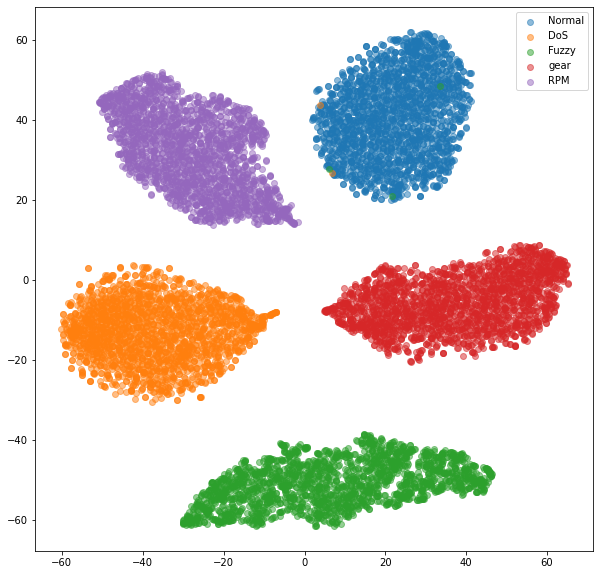

In [43]:
plot_embeddings(new_embs, total_label[indices])

# SupCon model

In [5]:
def change_state_dict(state_dict):
    """
    Because state dict in distributed GPU is different
    """
    new_state_dict = {}
    for k, v in state_dict.items():
        k = k.replace("module.", "")
        new_state_dict[k] = v
    return new_state_dict

In [9]:
import torch.optim as optim
from networks.classifier import LinearClassifier
from SupContrast.networks.resnet_big import SupConResNet

model = SupConResNet('resnet18')
classifier = LinearClassifier(n_classes=5, feat_dim=512)

In [10]:
classifier.__class__.__name__

'LinearClassifier'

In [17]:
save_path = './save/SupCon_resnet18_lr0.1_0.01_bs1024_200epoch_temp0.07_042622_213622_cosine_warm/'
ckpt_epoch = 200
# model_path = f'{save_path}/last.pth'
model_path = f'{save_path}/models/ckpt_epoch_{ckpt_epoch}.pth'
ckpt = torch.load(model_path)
state_dict = ckpt['model']
state_dict = change_state_dict(state_dict)
model.load_state_dict(state_dict=state_dict)

<All keys matched successfully>

In [18]:
class_model_path = f'{save_path}/models/ckpt_class_epoch_{ckpt_epoch}.pth'
# class_model_path = f'{save_path}/last.pth'
ckpt = torch.load(class_model_path)
state_dict = ckpt['model']
classifier.load_state_dict(state_dict=state_dict)

<All keys matched successfully>

In [32]:
import numpy as np
import tqdm
total_pred = np.empty(shape=(0), dtype=int)
total_label = np.empty(shape=(0), dtype=int)
total_embs = np.empty(shape=(0, 512), dtype=float)

model = model.cuda()
classifier = classifier.cuda()
model.eval()
classifier.eval()
with torch.no_grad():
    for images, labels in tqdm.tqdm(val_loader):
        images = images.cuda(non_blocking=True)
        embs = model.encoder(images)
        outputs = classifier(embs)
        _, pred = outputs.topk(1, 1, True, True)
        pred = pred.t().cpu().numpy().squeeze(0)
        embs = embs.cpu().numpy()
        total_embs = np.concatenate((total_embs, embs), axis=0)
        total_pred = np.concatenate((total_pred, pred), axis=0)
        total_label = np.concatenate((total_label, labels), axis=0)

100%|██████████| 162/162 [02:15<00:00,  1.19it/s]


In [33]:
from utils import cal_metric
cm, results = cal_metric(total_label, total_pred)
for key, values in results.items():
    print(list("{0:0.4f}".format(i) for i in values)) 

['0.0000', '0.0184', '0.0620', '0.0555', '0.0507']
['1.0000', '0.9998', '0.9994', '0.9994', '0.9995']
['0.9997', '1.0000', '1.0000', '1.0000', '1.0000']
['0.9998', '0.9999', '0.9997', '0.9997', '0.9997']


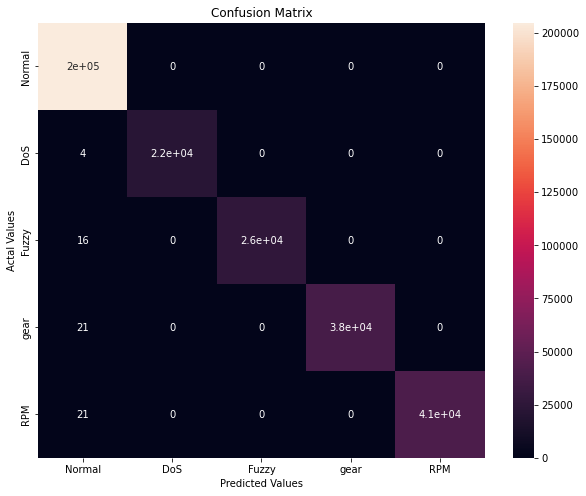

In [34]:
draw_confusion_matrix(cm)

In [23]:
np.random.seed(100)
indices = np.empty(shape=(0), dtype=int)
num_samples = 3000
n_classes=5
for c in range(n_classes):
    idx_c = np.where(total_label==c)[0]
    idx_c = np.random.choice(idx_c, num_samples, replace=True)
    indices = np.concatenate((indices, idx_c), axis=0)
indices.shape

(15000,)

In [24]:
tsne = TSNE(n_components=2, learning_rate='auto', init='random', n_jobs=-1)
new_embs = tsne.fit_transform(total_embs[indices])

In [25]:
plot_embeddings(new_embs, total_label[indices])

NameError: name 'plot_embeddings' is not defined

In [7]:
def extract_embedding(model, data_loader):
    model = model.cuda()
    embs = torch.empty(0, 576, dtype=torch.double).cuda()
    for data, labels in data_loader:
        data = data.cuda()
        with torch.no_grad():
            feats = model.encoder(data)
            embs = torch.cat((embs, feats), dim=0)
    return embs

In [12]:
model = model.cuda()
classifier = LinearClassifier(n_classes=5)
classifier = classifier.cuda()
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(classifier.parameters(), lr=0.01)

In [10]:
from SupContrast.util import AverageMeter
from SupContrast.util import accuracy
from tqdm import tqdm

In [13]:
epochs = 10
for epoch in range(epochs):
    model.eval()
    classifier.train()
    
    losses = AverageMeter()
    accs = AverageMeter()
    
    for data, labels in tqdm(train_loader):
        data = data.cuda()
        labels = labels.cuda()
        bsz = labels.shape[0]
        with torch.no_grad():
            feats = model.encoder(data)
            
        output = classifier(feats.detach())
        loss = criterion(output, labels)
        acc = accuracy(output, labels, topk=(1, ))
        losses.update(loss.item(), bsz)
        accs.update(acc[0], bsz)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch}: loss = {losses.avg}, acc = {accs.avg}')

100%|██████████| 3021/3021 [08:14<00:00,  6.12it/s]


Epoch 0: loss = 0.013830464898798547, acc = tensor([99.7984], device='cuda:0')


100%|██████████| 3021/3021 [08:11<00:00,  6.14it/s]


Epoch 1: loss = 0.004980118928648514, acc = tensor([99.8779], device='cuda:0')


100%|██████████| 3021/3021 [08:12<00:00,  6.13it/s]


Epoch 2: loss = 0.003958182051134632, acc = tensor([99.9030], device='cuda:0')


100%|██████████| 3021/3021 [08:18<00:00,  6.06it/s]


Epoch 3: loss = 0.003476453364120996, acc = tensor([99.9152], device='cuda:0')


100%|██████████| 3021/3021 [08:05<00:00,  6.23it/s]


Epoch 4: loss = 0.0031404419795380023, acc = tensor([99.9238], device='cuda:0')


100%|██████████| 3021/3021 [08:14<00:00,  6.11it/s]


Epoch 5: loss = 0.0028882115278304004, acc = tensor([99.9299], device='cuda:0')


100%|██████████| 3021/3021 [08:09<00:00,  6.17it/s]


Epoch 6: loss = 0.0026897753914607186, acc = tensor([99.9343], device='cuda:0')


100%|██████████| 3021/3021 [08:13<00:00,  6.13it/s]


Epoch 7: loss = 0.0025286218821368844, acc = tensor([99.9384], device='cuda:0')


100%|██████████| 3021/3021 [08:11<00:00,  6.15it/s]


Epoch 8: loss = 0.002394688842020142, acc = tensor([99.9426], device='cuda:0')


100%|██████████| 3021/3021 [08:13<00:00,  6.12it/s]

Epoch 9: loss = 0.0022813792193305577, acc = tensor([99.9459], device='cuda:0')
